# Counting blobs with pyclesperanto
A common use case for image processing in the biology context is counting blobs of high signal intensity surrounded by a low intensity background. Thresholding is the method of choice in this scenario. We demonstrate it with Otsu's thresholding method (Otsu et al., IEEE Transactions on Systems, Man, and Cybernetics, Vol. 9 (1), 1979)

In [1]:
import pyclesperanto_prototype as cle

from skimage.io import imread, imsave, imshow
import matplotlib
import numpy as np

# initialize GPU
cle.select_device("GTX")
print("Used GPU: " + cle.get_device().name)

Used GPU: GeForce RTX 2080 Ti


In [2]:
# load data
image = imread('https://samples.fiji.sc/blobs.png')
print("Loaded image size: " + str(image.shape))

# push image to GPU memory
input = cle.push(image)
print("Image size in GPU: " + str(input.shape))

Loaded image size: (254, 256)
Image size in GPU: (254, 256)


## Image processing using pyclesperanto

After initializing GPU and pushing images there, workflows are constructed like this:

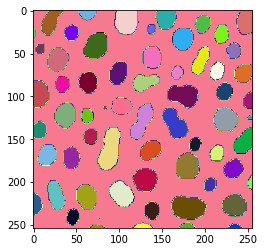

Number of objects in the image: 63.0


In [3]:
# process the image
blurred = cle.gaussian_blur(input, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred)
labeled = cle.connected_components_labeling_box(binary)

# show result
cle.imshow(labeled, labels=True)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

When processing multiple images subsequently, it might make sense to re-use memory like shown in the following. In that way, some time can be spared for not re-allocating images over and over.

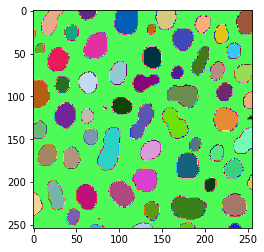

Number of objects in the image: 63.0


In [4]:
# process the image
blurred = cle.gaussian_blur(input, blurred, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred, binary)
labeled = cle.connected_components_labeling_box(binary, labeled)

# show result
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
cle.imshow(labeled, labels=True)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

## Addendum: Remove labels on edges
In case the size of the objects is relevant, one should exclude the object which were not fully imaged and thus, touch the image border.

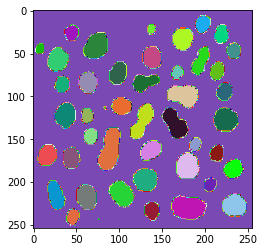

Number of objects in the image: 45.0


In [5]:
# Exclude Labels On Edges
labels_excl_edges = cle.exclude_labels_on_edges(labeled)

# show result
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
cle.imshow(labels_excl_edges, labels=True)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labels_excl_edges)
print("Number of objects in the image: " + str(num_labels))